## AWS Rekognition from python
- boto3 is the python bindings for aws allowing to do any thing from python to aws
- To install boto3 in python ---> conda install -c anaconda boto3

In [1]:
import boto3

### Check our connection

In [2]:
s3 = boto3.resource('s3')

### Display all buckets

In [4]:
print(s3.buckets.all())

s3.bucketsCollection(s3.ServiceResource(), s3.Bucket)


In [5]:
for bucket in s3.buckets.all():
    print(bucket)

s3.Bucket(name='saquib-bucket')


## Display all instances

In [6]:
ec2 = boto3.resource('ec2')

In [8]:
for ins in ec2.instances.all():
    print(ins)

ec2.Instance(id='i-0f594d8a31b8dcd11')


In [9]:
for ins in ec2.instances.all():
    print(ins.id,ins.state)

i-0f594d8a31b8dcd11 {'Name': 'stopped', 'Code': 80}


## Working with the Rekognition

In [2]:
import requests

# get raw image data given a url.
def get_image_from_url(imgurl):
    resp = requests.get(imgurl)
    imgbytes = resp.content
    return imgbytes

# get image from a file directly.
def get_img_from_file(filename):
    with open(filename,'rb') as imgfile:
        return imgfile.read()


## Create a boto3 client

In [3]:
client = boto3.client('rekognition')

## Face recognition

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
import os

In [5]:
filename = 'images/'+'image-12.jpg'
filename1 = 'images/'+ 'my_pick.jpg'
imgbytes = get_img_from_file(filename)
imgbytes1 = get_img_from_file(filename1)
resp = client.compare_faces(SourceImage={'Bytes':imgbytes},TargetImage={'Bytes':imgbytes1})

In [6]:
resp

{'FaceMatches': [{'Face': {'BoundingBox': {'Height': 0.657706618309021,
     'Left': 0.07986549288034439,
     'Top': 0.04003431648015976,
     'Width': 0.9667927622795105},
    'Confidence': 99.94277954101562,
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.4502108097076416,
      'Y': 0.26408711075782776},
     {'Type': 'eyeRight', 'X': 0.7890982031822205, 'Y': 0.3416551351547241},
     {'Type': 'nose', 'X': 0.6334245800971985, 'Y': 0.4425392150878906},
     {'Type': 'mouthLeft', 'X': 0.3727918565273285, 'Y': 0.5058587193489075},
     {'Type': 'mouthRight', 'X': 0.6783850193023682, 'Y': 0.5592833161354065}],
    'Pose': {'Pitch': 0.37379851937294006,
     'Roll': 17.677095413208008,
     'Yaw': 14.757283210754395},
    'Quality': {'Brightness': 41.476951599121094,
     'Sharpness': 99.9945297241211}},
   'Similarity': 92.0}],
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '946',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fr

In [23]:
ima = plt.imread('images/'+'image-12.jpg')

In [24]:
type(ima.read())

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [22]:
resp['FaceMatches'][0]['Similarity']

92.0

In [22]:
def show_output(name,print_res = False,confid=None,image_bytes = None):
    filename = 'images/'+name
    image = plt.imread(filename)
    ih,iw,ic = image.shape
    print(ih,iw)
    imgbytes = get_img_from_file(filename)
    rekresp = client.detect_faces(Image={'Bytes':imgbytes},Attributes=['ALL'])
    count = 0
    numfaces = len(rekresp['FaceDetails'])
    print('Found', numfaces, end='')
    if numfaces == 1:
        print(' face:')
    else:
        print(' faces:')

    for facedeets in rekresp['FaceDetails']:

        # construct a printf (almost) style format string for printing the info
        fmtstr = '{gender} age {lowage}-{highage},'
        BB = facedeets['BoundingBox']
        h,l,t,w = BB['Height'],BB['Left'],BB['Top'],BB['Width']
        img_s = image[int(max(0,ih*t)):int(max(0,ih*t)+ih*h),int(max(0,iw*l)):int(max(0,iw*l)+iw*w)] 
        """
        The bounding box coordinates can have negative values. For example, if Amazon Rekognition is able to detect 
        a face that is at the image edge and is only partially visible, the service can return coordinates 
        that are outside the image bounds and, depending on the image edge,
        you might get negative values or values greater than 1 for the left or top values.
        """
        if image_bytes == None:
            plt.imshow(img_s,shape=img_s.shape,interpolation='bicubic',aspect='auto')
            plt.figure()
            #print(ih*h,iw*l,ih*t,iw*w)
            # mustache and beard detection
            if facedeets['Mustache']['Value'] and facedeets['Beard']['Value']:
                fmtstr += ' with beard and mustache,'
            elif facedeets['Mustache']['Value']:
                fmtstr += ' with mustache,'
            elif facedeets['Beard']['Value']:
                fmtstr += ' with beard,'

            # sunglasses/eyeglasses detection
            if facedeets['Sunglasses']['Value']:
                fmtstr += ' wearing sunglasses,'
            elif facedeets['Eyeglasses']['Value']:
                fmtstr += ' wearing glasses,'

            fmtstr += ' looks {emotion}'
            fmtstr += ', With Confidence :{confident}'
            if confid == None:
                Emotion = facedeets['Emotions'][0]['Type'].lower()
            else:
                if facedeets['Emotions'][0]['Confidence'] < confid:
                    Emotion = 'sad'
                else:
                    Emotion = 'Happy'

            print(
                fmtstr.format(
                    gender=facedeets['Gender']['Value'],
                    lowage=facedeets['AgeRange']['Low'],
                    highage=facedeets['AgeRange']['High'],
                    emotion=Emotion,
                    confident=facedeets['Emotions'][0]['Confidence']
                )
            )

            plt.show()
            if Emotion == 'sad':
                count = count + 1
        else:
            plt.imsave('gipp.jpg',img_s)
            filename = 'gipp.jpg'
            imgbytes1 = get_img_from_file(filename)
            resp = client.compare_faces(SourceImage={'Bytes':image_bytes},TargetImage={'Bytes':imgbytes1})
            if len(resp['FaceMatches']) !=0 and resp['FaceMatches'][0]['Similarity'] >= 75:
                print('This is the result for the given person with its cropped image from the source image:')
                plt.imshow(img_s,shape=img_s.shape,interpolation='bicubic',aspect='auto')
                plt.figure()
                if facedeets['Mustache']['Value'] and facedeets['Beard']['Value']:
                    fmtstr += ' with beard and mustache,'
                elif facedeets['Mustache']['Value']:
                    fmtstr += ' with mustache,'
                elif facedeets['Beard']['Value']:
                    fmtstr += ' with beard,'

                # sunglasses/eyeglasses detection
                if facedeets['Sunglasses']['Value']:
                    fmtstr += ' wearing sunglasses,'
                elif facedeets['Eyeglasses']['Value']:
                    fmtstr += ' wearing glasses,'

                fmtstr += ' looks {emotion}'
                fmtstr += ', With Confidence :{confident}'
                if confid == None:
                    Emotion = facedeets['Emotions'][0]['Type'].lower()
                else:
                    if facedeets['Emotions'][0]['Confidence'] < confid:
                        Emotion = 'sad'
                    else:
                        Emotion = 'Happy'

                print(
                    fmtstr.format(
                        gender=facedeets['Gender']['Value'],
                        lowage=facedeets['AgeRange']['Low'],
                        highage=facedeets['AgeRange']['High'],
                        emotion=Emotion,
                        confident=facedeets['Emotions'][0]['Confidence']
                    )
                )

                plt.show()
                if Emotion == 'sad':
                    count = count + 1
            os.remove('gipp.jpg')
        
    if image_bytes == None:
        print('The Total number of people sad in the image are :',count)

1920 2560
Found 3 faces:
Male age 26-43, with beard, wearing glasses, looks happy, With Confidence :70.77816009521484


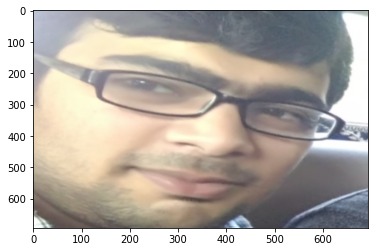

Male age 20-38, with beard and mustache, looks happy, With Confidence :68.88685607910156


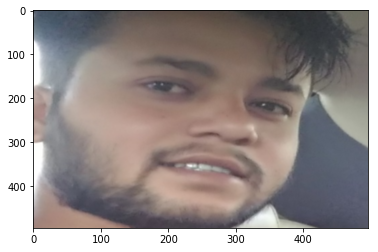

Male age 26-43, looks happy, With Confidence :34.519325256347656


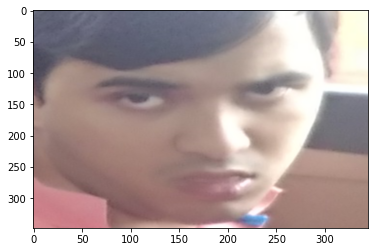

The Total number of people sad in the image are : 0


In [10]:
show_output(name='P_20170415_154954_BF.jpg')

251 201
Found 1 face:
Female age 20-38, looks sad, With Confidence :69.60124206542969


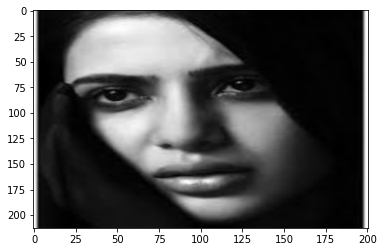

The Total number of people sad in the image are : 1


In [111]:
show_output(name='images (2).jpeg')

320 450
Found 5 faces:
Male age 35-53, with beard and mustache, looks happy, With Confidence :52.112571716308594


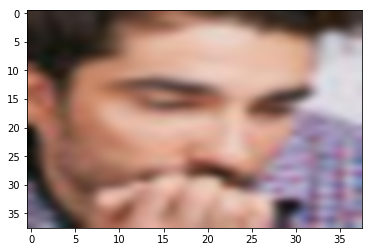

Male age 26-43, with beard and mustache, looks sad, With Confidence :10.09252643585205


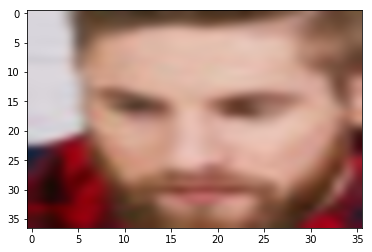

Male age 29-45, with beard and mustache, looks angry, With Confidence :46.08902359008789


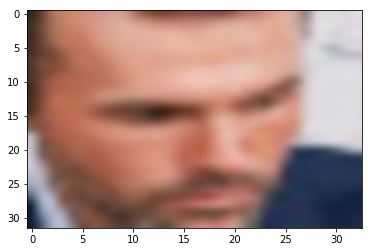

Female age 26-43, looks happy, With Confidence :79.08189392089844


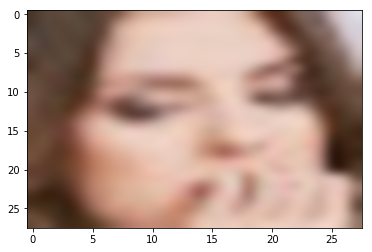

Female age 30-47, looks happy, With Confidence :93.50666046142578


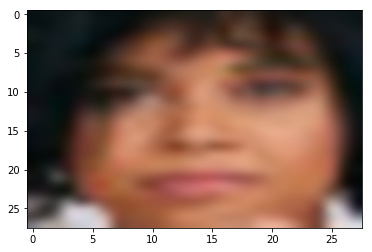

The Total number of people sad in the image are : 1


In [112]:
show_output(name='stock-photo-group-of-stressful-university-students-waiting-for-exam-test-481536121.jpg')

190 266
Found 3 faces:
Male age 48-68, looks happy, With Confidence :18.954103469848633


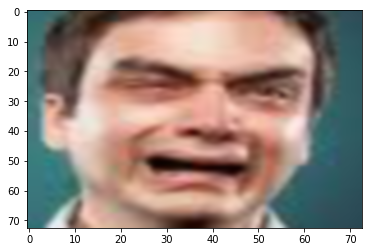

Male age 45-66, looks sad, With Confidence :55.368865966796875


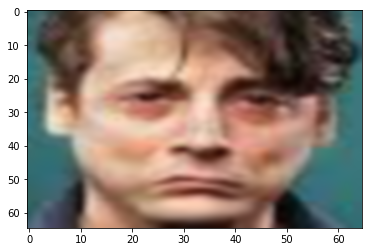

Male age 45-63, wearing glasses, looks happy, With Confidence :6.986259460449219


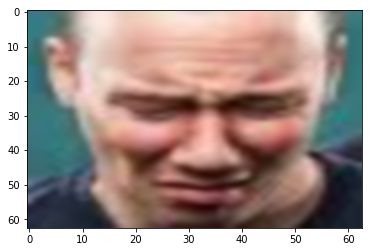

The Total number of people sad in the image are : 1


In [113]:
filename = 'download.jpeg'
show_output(name=filename)

## Observations :
- As we can see that the program says people happy/calm with confidence level less than 60.
- In a practical situation in problem of ``Sad face detection `` we would want our model to be robust,
    - So we may ignore calm expression as it is a intermediate of Happy and sad
    - Classify happy only if the confidence is grater than 50 %.

1920 2560
Found 3 faces:
Male age 26-43, with beard, wearing glasses, looks Happy, With Confidence :70.77816009521484


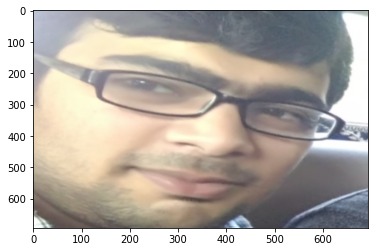

Male age 20-38, with beard and mustache, looks Happy, With Confidence :68.88685607910156


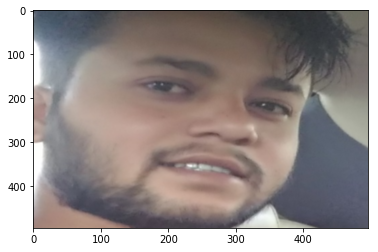

Male age 26-43, looks sad, With Confidence :34.519325256347656


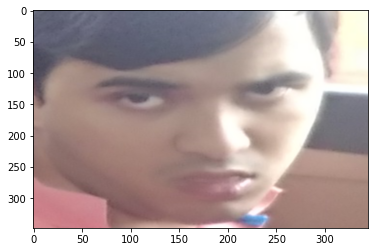

The Total number of people sad in the image are : 1


In [117]:
show_output(name='P_20170415_154954_BF.jpg',confid = 50)

320 450
Found 5 faces:
Male age 35-53, with beard and mustache, looks Happy, With Confidence :52.112571716308594


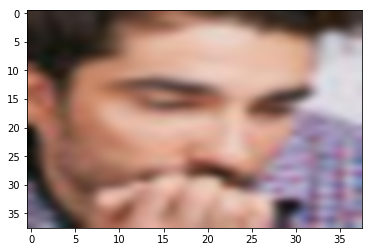

Male age 26-43, with beard and mustache, looks sad, With Confidence :10.09252643585205


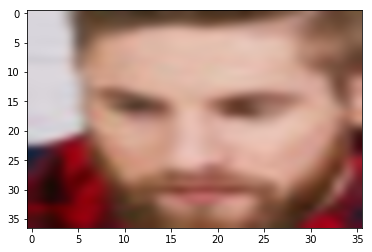

Male age 29-45, with beard and mustache, looks sad, With Confidence :46.08902359008789


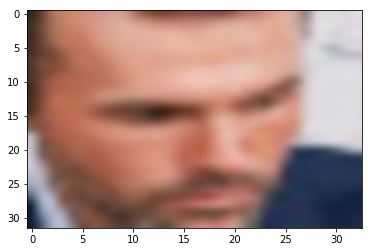

Female age 26-43, looks Happy, With Confidence :79.08189392089844


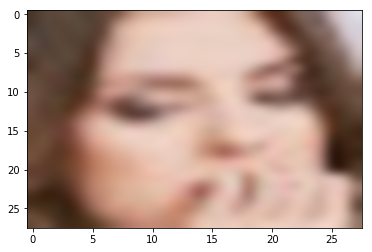

Female age 30-47, looks Happy, With Confidence :93.50666046142578


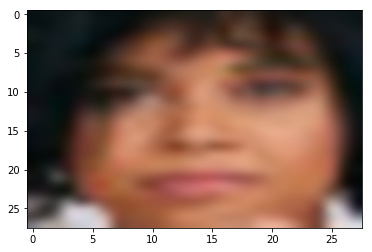

The Total number of people sad in the image are : 2


In [118]:
show_output(name='stock-photo-group-of-stressful-university-students-waiting-for-exam-test-481536121.jpg',confid=50)

190 266
Found 3 faces:
Male age 48-68, looks sad, With Confidence :18.954103469848633


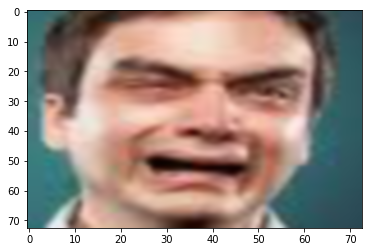

Male age 45-66, looks Happy, With Confidence :55.368865966796875


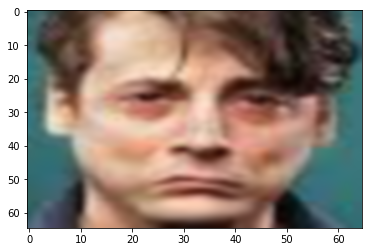

Male age 45-63, wearing glasses, looks sad, With Confidence :6.986259460449219


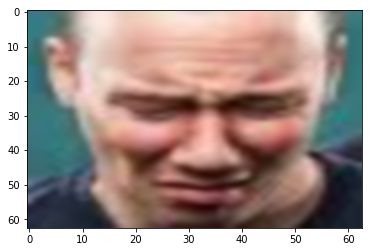

The Total number of people sad in the image are : 2


In [119]:
filename = 'download.jpeg'
show_output(name=filename,confid = 50)

- Here we see that even on 50 threshold we recieve a wrong result, so we can move to say 60% threshold

190 266
Found 3 faces:
Male age 48-68, looks sad, With Confidence :18.954103469848633


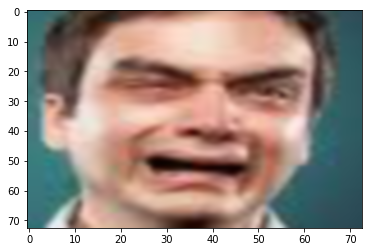

Male age 45-66, looks sad, With Confidence :55.368865966796875


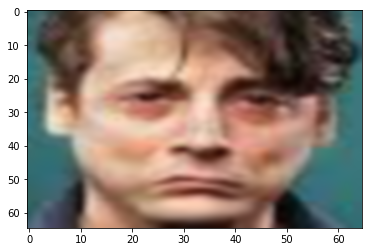

Male age 45-63, wearing glasses, looks sad, With Confidence :6.986259460449219


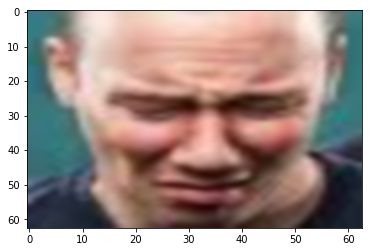

The Total number of people sad in the image are : 3


In [120]:
filename = 'download.jpeg'
show_output(name=filename,confid = 60)

192 262
Found 6 faces:
Male age 57-77, with beard and mustache, looks sad, With Confidence :25.37851333618164


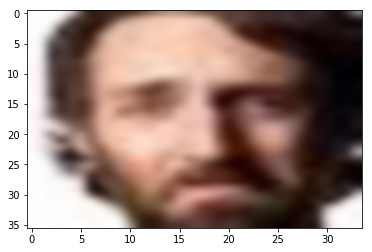

Female age 26-43, looks sad, With Confidence :53.014068603515625


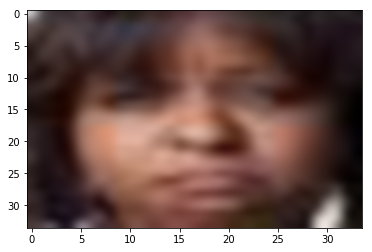

Female age 26-43, wearing sunglasses, looks sad, With Confidence :53.034912109375


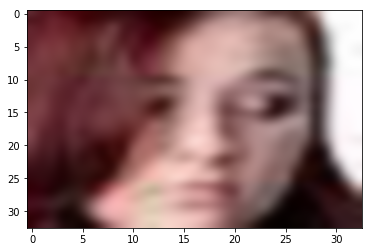

Male age 35-52, looks sad, With Confidence :7.456579685211182


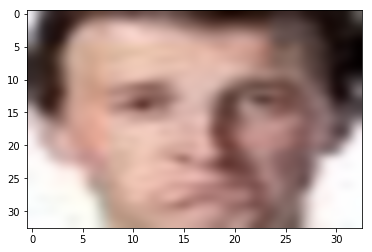

Male age 35-52, looks Happy, With Confidence :85.96110534667969


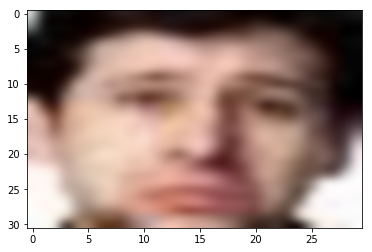

Female age 26-44, wearing glasses, looks sad, With Confidence :58.00776672363281


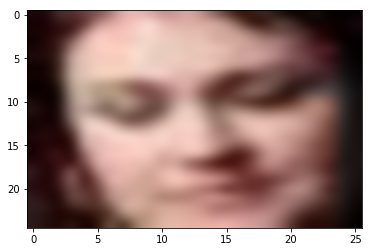

The Total number of people sad in the image are : 5


In [122]:
filename = 'images-3.jpeg'
show_output(name=filename,confid = 60)

## Now if we want to see if a particular person is happy or sad in a photo
- For that perpose we need to input the image of that particular person.

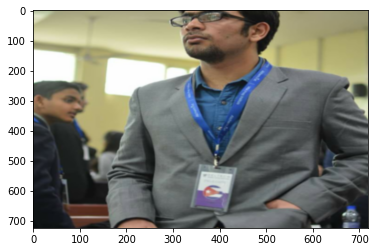

1920 2560
Found 3 faces:
This is the result for the given person with its cropped image from the source image:
Male age 26-43, with beard, wearing glasses, looks happy, With Confidence :70.77816009521484


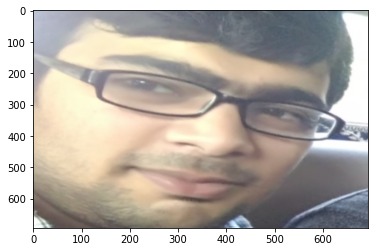

In [24]:
filename1 = 'images/'+ 'image-12.jpg'
imaG = plt.imread(filename1)
plt.figure()
plt.imshow(imaG,interpolation='bicubic',aspect='auto')
plt.show()
imageB = get_img_from_file(filename1)
show_output(name='P_20170415_154954_BF.jpg',image_bytes=imageB)